In [22]:
# Step 1: Imports & Load Data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression

In [13]:
data=pd.read_csv("C:/Users/cmgou/Documents/Meta scifor/Test 9.0/Test 9.0/SAP-4000.csv")
data.head()

,Gender,HoursStudied/Week,Tutoring,Region,Attendance(%),Parent Education,Exam_Score
0,Male,5.5,No,Urban,72.7,Tertiary,43.5
1,Female,6.8,No,Urban,62.0,Primary,51.7
2,Female,9.7,No,Rural,95.0,Secondary,70.1
3,Male,13.3,Yes,Rural,52.9,NaN,79.5
4,Female,8.9,No,Urban,50.8,NaN,52.2


In [14]:
data.shape

(4000, 7)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             4000 non-null   object 
 1   HoursStudied/Week  4000 non-null   float64
 2   Tutoring           4000 non-null   object 
 3   Region             4000 non-null   object 
 4   Attendance(%)      4000 non-null   float64
 5   Parent Education   3578 non-null   object 
 6   Exam_Score         4000 non-null   float64
dtypes: float64(3), object(4)
memory usage: 218.9+ KB


In [16]:
data.isna().sum()

Gender                 0
HoursStudied/Week      0
Tutoring               0
Region                 0
Attendance(%)          0
Parent Education     422
Exam_Score             0
dtype: int64

In [17]:
data['Parent Education'].value_counts()


Parent Education
Secondary    1590
Tertiary     1175
Primary       813
Name: count, dtype: int64

In [18]:
data['Parent Education'].unique()


array(['Tertiary', 'Primary', 'Secondary', nan], dtype=object)

In [23]:
label_encoder = preprocessing.LabelEncoder()
data['Parent Education']= label_encoder.fit_transform(data['Parent Education'])

data['Parent Education'].unique()

array([2, 0, 1, 3])

In [24]:
# One-hot encoding for nominal categorical features
data = pd.get_dummies(data, columns=['Gender', 'Region', 'Tutoring'], drop_first=True)

In [25]:
 scaler = StandardScaler()
data[['HoursStudied/Week', 'Attendance(%)']] = scaler.fit_transform(data[['HoursStudied/Week', 'Attendance(%)']])

In [26]:
scaler

StandardScaler()

In [27]:
# Step 3: Feature Selection
x = data.drop('Exam_Score', axis=1)
y = data['Exam_Score']


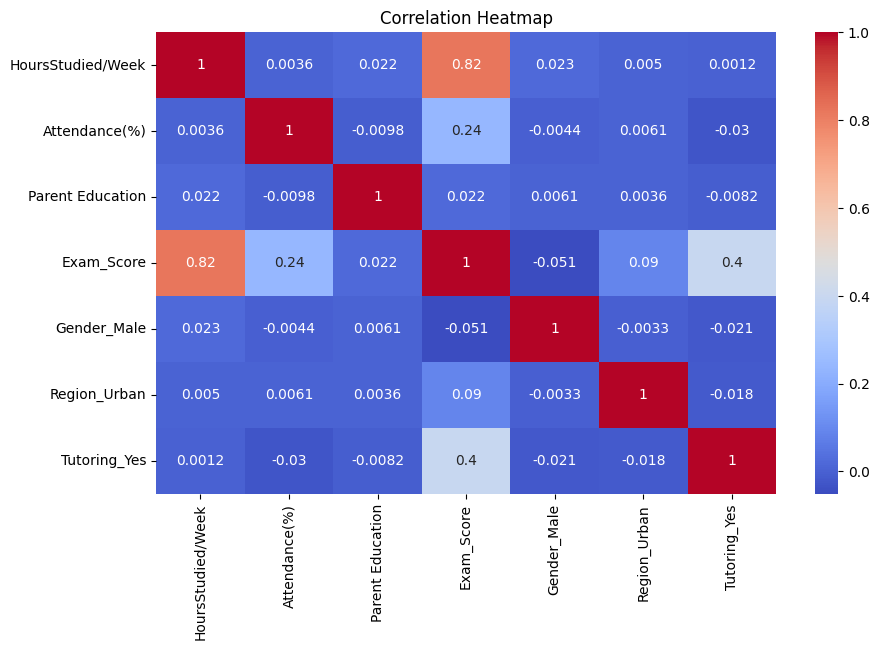

In [28]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [29]:
# Apply SelectKBest
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(x, y)



SelectKBest(k='all', score_func=<function f_regression at 0x00000251FC8AF4C0>)

In [30]:
feature_scores = pd.DataFrame({'Feature': x.columns, 'Score': selector.scores_})
print(feature_scores.sort_values(by='Score', ascending=False))

             Feature        Score
0  HoursStudied/Week  8194.409160
5       Tutoring_Yes   742.776741
1      Attendance(%)   241.280885
4       Region_Urban    32.933088
3        Gender_Male    10.425933
2   Parent Education     1.901854


In [31]:
# Step 4: Train/Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [32]:
# Step 5: Train Models
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [33]:
# Train Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=42)
dt.fit(x_train, y_train)

DecisionTreeRegressor(random_state=42)

In [34]:
def evaluate_model(name, model, x_train, x_test, y_train, y_test):
    
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    print("Train R2 Score:", r2_score(y_train, y_train_pred))
    print("Test R2 Score:", r2_score(y_test, y_test_pred))
    
    print("Test MAE:", mean_absolute_error(y_test, y_test_pred))
    print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))


In [36]:
evaluate_model("Linear Regression", lr, x_train, x_test, y_train, y_test)
evaluate_model("Decision Tree", dt, x_train, x_test, y_train, y_test)


Train R2 Score: 0.899277634553574
Test R2 Score: 0.9088827306951802
Test MAE: 4.1474562751445445
Test RMSE: 5.222466761773294
Train R2 Score: 0.9997619993335368
Test R2 Score: 0.8208193809958488
Test MAE: 5.6503749999999995
Test RMSE: 7.323536543228278


In [37]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

lr_scores = cross_val_score(lr, x, y, cv=cv, scoring='r2')
dt_scores = cross_val_score(dt, x, y, cv=cv, scoring='r2')

print("Linear Regression CV R²:", np.mean(lr_scores))
print("Decision Tree CV R²:", np.mean(dt_scores))


Linear Regression CV R²: 0.900892104879213
Decision Tree CV R²: 0.7974711864750142


In [38]:
params = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid=params, cv=5, scoring='r2')
grid.fit(x_train, y_train)

print("Best Parameters:", grid.best_params_)
best_dt = grid.best_estimator_

# Evaluate the tuned model
evaluate_model("Tuned Decision Tree", best_dt, x_train, x_test, y_train, y_test)


Best Parameters: {'max_depth': 5, 'min_samples_split': 2}
Train R2 Score: 0.8728496009531378
Test R2 Score: 0.8636628895285596
Test MAE: 4.999265555476731
Test RMSE: 6.388256997239511


In [39]:
y_pred = best_dt.predict(x_test)

y_pred

array([67.53056769, 60.34193548, 91.20454545, 93.32713178, 64.83125   ,
       67.53056769, 86.32131148, 73.34027778, 54.26160338, 73.13760684,
       58.1462963 , 73.91741294, 67.53056769, 54.26160338, 54.26160338,
       73.91741294, 41.27328244, 73.91741294, 58.1462963 , 82.47402597,
       86.32131148, 95.79411765, 80.0245614 , 45.22643678, 73.91741294,
       60.59384615, 67.38584071, 87.6       , 73.13760684, 67.53056769,
       82.47402597, 89.72708333, 58.1462963 , 67.38584071, 96.11038961,
       93.32713178, 86.09480519, 73.13760684, 41.27328244, 81.2234375 ,
       52.57058824, 81.71360947, 58.1462963 , 67.53056769, 65.58421053,
       81.71360947, 86.09480519, 67.53056769, 86.32131148, 73.91741294,
       67.53056769, 81.2234375 , 67.38584071, 67.53056769, 54.26160338,
       52.57058824, 81.71360947, 67.53056769, 81.71360947, 74.93      ,
       80.0245614 , 67.38584071, 86.32131148, 65.58421053, 60.59384615,
       28.77826087, 74.93      , 80.0245614 , 67.38584071, 99.33

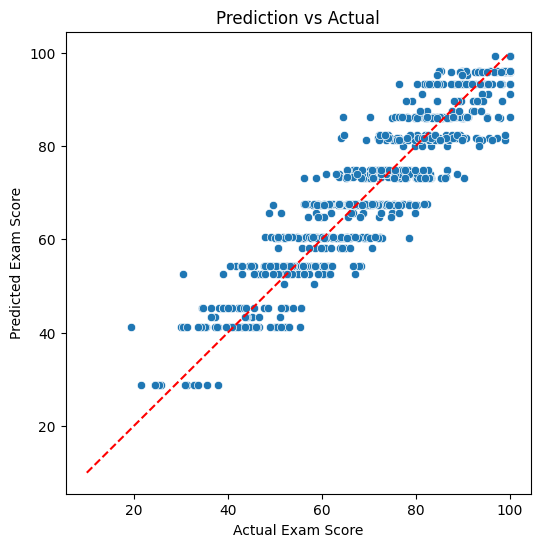

In [41]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Exam Score")
plt.ylabel("Predicted Exam Score")
plt.title("Prediction vs Actual")
plt.plot([10, 100], [10, 100], 'r--')
plt.show()
